In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import cv2
import random
from imgaug import augmenters as iaa

from keras.layers import Conv1D, MaxPool1D, Dropout, Flatten
import keras
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

data= pd.read_csv('data/self_driving_car_dataset_make/driving_log.csv',names = columns)

In [3]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,IMG\center_2022_04_10_12_24_41_840.jpg,IMG\left_2022_04_10_12_24_41_840.jpg,IMG\right_2022_04_10_12_24_41_840.jpg,0.0,0.0,0,0.000013
1,IMG\center_2022_04_10_12_24_41_908.jpg,IMG\left_2022_04_10_12_24_41_908.jpg,IMG\right_2022_04_10_12_24_41_908.jpg,0.0,0.0,0,0.000010
2,IMG\center_2022_04_10_12_24_41_976.jpg,IMG\left_2022_04_10_12_24_41_976.jpg,IMG\right_2022_04_10_12_24_41_976.jpg,0.0,0.0,0,0.000008
3,IMG\center_2022_04_10_12_24_42_044.jpg,IMG\left_2022_04_10_12_24_42_044.jpg,IMG\right_2022_04_10_12_24_42_044.jpg,0.0,0.0,0,0.000021
4,IMG\center_2022_04_10_12_24_42_116.jpg,IMG\left_2022_04_10_12_24_42_116.jpg,IMG\right_2022_04_10_12_24_42_116.jpg,0.0,0.0,0,0.000014


In [4]:
data.shape

(3930, 7)

In [5]:
data.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'], dtype='object')

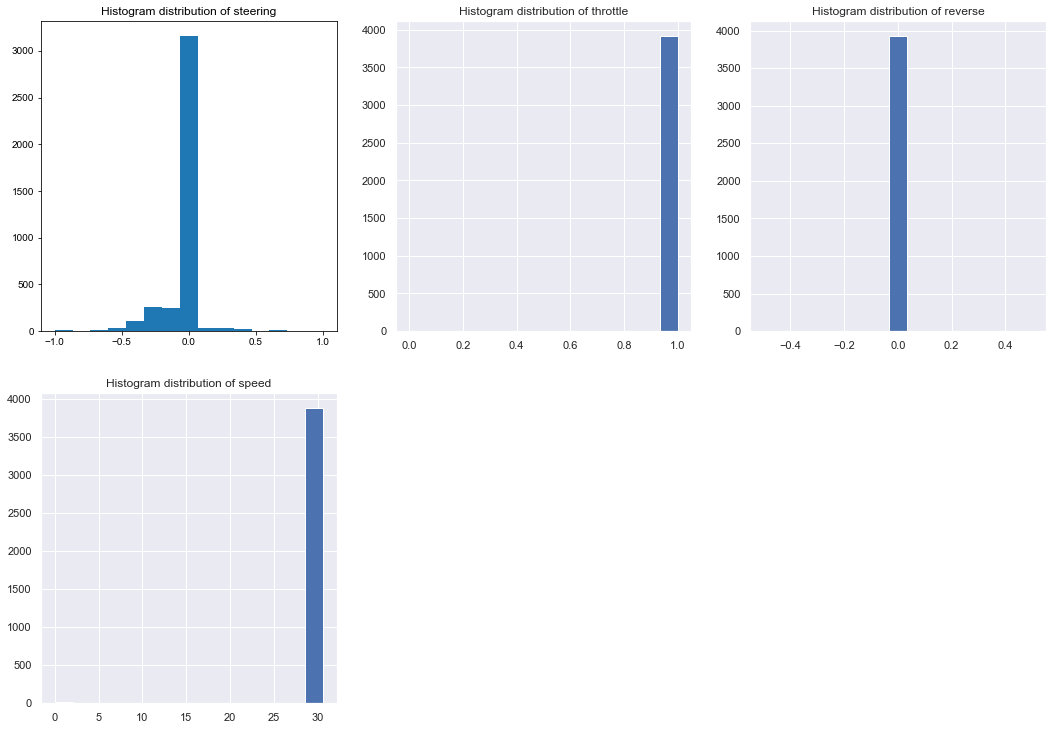

In [6]:

num_cols= ['steering', 'throttle', 'reverse', 'speed']

plt.figure(figsize=(18,18))
for i,j in zip(range(1,18),num_cols):
    plt.subplot(6, 3, i)
    plt.subplots_adjust(right=0.9,top=1.8)
    plt.hist(data[j], bins = 15)
    sns.set_theme()
    plt.title('Histogram distribution of {}'.format(j))



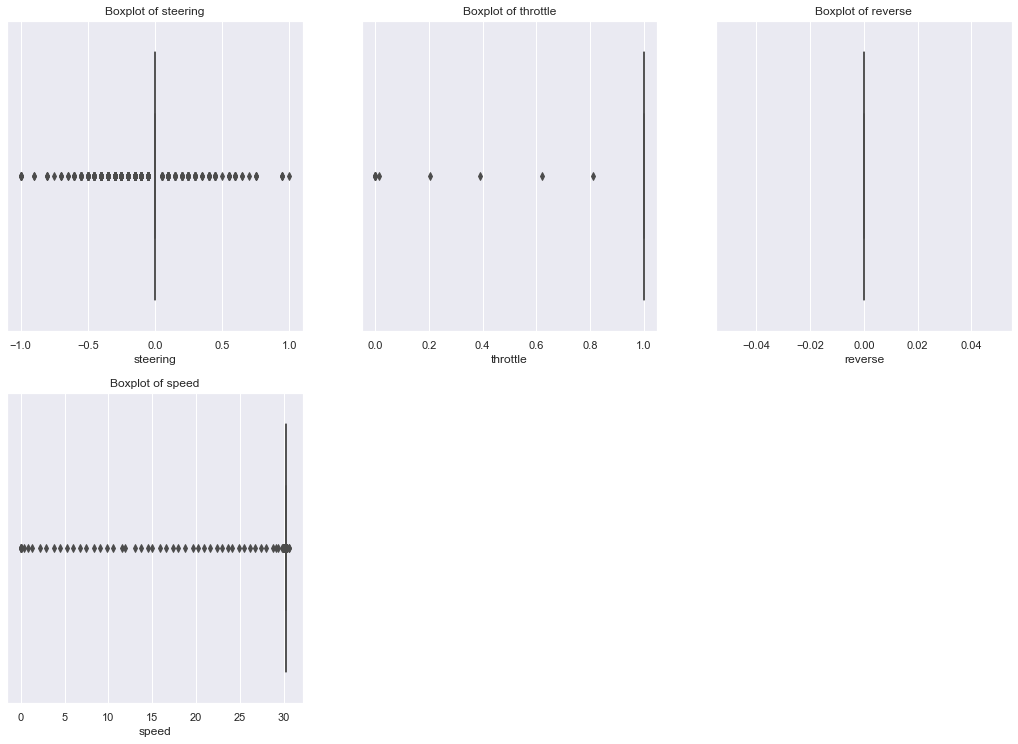

In [7]:
plt.figure(figsize=(18,18))
for i,j in zip(range(1, 18),num_cols):
    plt.subplot(6, 3, i)
    plt.subplots_adjust(right=0.9,top=1.8)
    sns.boxplot(data=data, x=j)
    sns.set_theme()
    plt.title('Boxplot of {}'.format(j))

In [8]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [9]:
datadir = ''
image_paths, steerings = load_img_steering(datadir + 'data/self_driving_car_dataset_make/', data)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.3, random_state=42)

In [11]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

# Image data preprocessing

In [12]:
def img_preprocess(img):
    # extracting the important parts of image
    img = img[60:135,:,:]
    
    # converting the RGB image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    # Applying gaussian blur
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    
    # resizing the image
    img = cv2.resize(img, (200, 66))
    
    # scaling the image 
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

In [13]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

In [14]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [15]:
y_test.shape

(3537,)

# Convolutional neural network

In [16]:
from tensorflow.keras.applications import DenseNet121

In [17]:
def create_network():
    model = Sequential()
    model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="relu"))
    model.add(Convolution2D(36,(5,5),strides=(2,2),activation="relu"))
    model.add(Convolution2D(48,(5,5),strides=(2,2),activation="relu"))
    model.add(Convolution2D(64,(3,3),activation="relu"))
    model.add(Convolution2D(64,(3,3),activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(50,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation="relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=1e-3),loss="mse")
    
    return model


In [18]:
model = create_network()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

C:\Users\Abhishek\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=7,
                                  validation_data=batch_generator(X_test, y_test, 100, 0),
                                  validation_steps=200,
                                  verbose=1)

Epoch 1/7
300/300 [==============================] - 161s 536ms/step - loss: 0.0335 - val_loss: 0.0366
Epoch 2/7
300/300 [==============================] - 129s 432ms/step - loss: 0.0327 - val_loss: 0.0357
Epoch 3/7
300/300 [==============================] - 129s 430ms/step - loss: 0.0339 - val_loss: 0.0348
Epoch 4/7
300/300 [==============================] - 128s 428ms/step - loss: 0.0334 - val_loss: 0.0348
Epoch 5/7
300/300 [==============================] - 128s 429ms/step - loss: 0.0340 - val_loss: 0.0360
Epoch 6/7
300/300 [==============================] - 128s 427ms/step - loss: 0.0334 - val_loss: 0.0358
Epoch 7/7
300/300 [==============================] - 129s 431ms/step - loss: 0.0339 - val_loss: 0.0368


In [25]:
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.show()

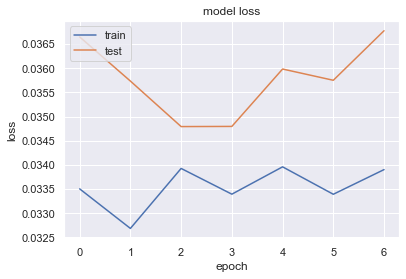

In [22]:
loss(history)

In [23]:
model.save('cnn_model.h5')

In [24]:
val_mae = history.history['loss']
print(val_mae)

[0.03350457549095154, 0.03268667683005333, 0.03392695635557175, 0.03339473158121109, 0.03395993635058403, 0.033392827957868576, 0.03390279412269592]


# DenseNet121

In [20]:

dnet = DenseNet121(
    weights='imagenet',
    input_shape=(66,200,3),
    include_top=False,
    pooling='max'
)

model_dnet = Sequential()
model_dnet.add(dnet)
model_dnet.add(Dense(units = 120, activation='relu'))
model_dnet.add(Dense(units = 120, activation = 'relu'))
model_dnet.add(Dense(units = 1))
model_dnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_4 (Dense)             (None, 120)               123000    
                                                                 
 dense_5 (Dense)             (None, 120)               14520     
                                                                 
 dense_6 (Dense)             (None, 1)                 121       
                                                                 
Total params: 7,175,145
Trainable params: 7,091,497
Non-trainable params: 83,648
_________________________________________________________________


In [21]:
model_dnet.compile(optimizer=Adam(lr=0.01),loss="mse")

In [22]:
history = model_dnet.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=7,
                                  validation_data=batch_generator(X_test, y_test, 100, 0),
                                  validation_steps=200,
                                  verbose=1)

Epoch 1/7
300/300 [==============================] - 2135s 7s/step - loss: 20.6255 - val_loss: 0.0423
Epoch 2/7
300/300 [==============================] - 1890s 6s/step - loss: 0.0351 - val_loss: 0.2274
Epoch 3/7
300/300 [==============================] - 1927s 6s/step - loss: 0.0298 - val_loss: 0.0303
Epoch 4/7
300/300 [==============================] - 1878s 6s/step - loss: 0.0232 - val_loss: 0.0262
Epoch 5/7
300/300 [==============================] - 1913s 6s/step - loss: 0.0211 - val_loss: 0.0237
Epoch 6/7
300/300 [==============================] - 1888s 6s/step - loss: 0.0209 - val_loss: 0.0412
Epoch 7/7
300/300 [==============================] - 1992s 7s/step - loss: 0.0191 - val_loss: 0.0173


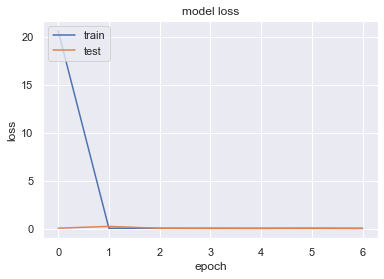

In [26]:
loss(history)

In [29]:
model_dnet.save('dnet.h5')

In [30]:
val_mae = history.history['loss']
print(val_mae)

[20.62554359436035, 0.035051409155130386, 0.029766840860247612, 0.023160526528954506, 0.02111552283167839, 0.02091629058122635, 0.019089367240667343]
